# Synthesize Human Speech with WaveNet

このNotebookは、[ChainerのWaveNetの例](https://chainer-colab-notebook.readthedocs.io/ja/latest/notebook/official_example/wavenet.html)をPytorch用に書き換えたものです。

WaveNetを動かす最低限とデータの確認用のコードに絞っています。

Colaboratoryの「ランタイムのタイプ」がGPUであれば、GPUをバックエンドとしてPytorchを動かすことができます。

学習データのダウンロードの高速化にaria2、音声処理にlibrosa、進捗バーの表示にtqdmを使うので、ここでインストールします。

In [1]:
!apt -y -q install aria2
!pip install -q librosa tqdm

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libc-ares2
The following NEW packages will be installed:
  aria2 libc-ares2
0 upgraded, 2 newly installed, 0 to remove and 10 not upgraded.
Need to get 1,274 kB of archives.
After this operation, 4,912 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libc-ares2 amd64 1.14.0-1 [37.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 aria2 amd64 1.33.1-1 [1,236 kB]
Fetched 1,274 kB in 1s (1,641 kB/s)
Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 146442 files and directories currently installed.)
Preparing to unpack .../libc-ares2_1.14.0-1_amd64.deb ...
Unpacking libc-ares2:amd64 (1.14.0-1) ...
Selecting previously unselected package aria2.
Preparing to unpack .../aria2_1.33.1-1_amd64.deb ...
Unpacking aria2 (1.33.1-1) ...
Setting up libc-ares2:amd64 (1.14.0

#Google ドライブにデータを保存する準備

WaveNetの学習にはとても時間がかかります。そのため、Google Drive に経過を保存できるように、マウントしておきましょう。(参考)

Colaboratory は、12時間を超えて継続できません。また、90分アイドルが続くと、ランタイムは解放されます。その他の制限は、こちらが詳しいです。

次のコードセルをを実行し、以下の手順で Google アカウントの認証を行います。

1. URLが表示されるのでそれをクリック
2. Google アカウントにログイン
3. 表示されるトークンをコピー
4. このノートに戻って、テキストボックスにそのトークンを貼り付け
5. 再度URLが表示されるのでそれをクリック
6. このノートに戻って、テキストボックスにそのトークンを貼り付け

In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools > /dev/null
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse > /dev/null

from google.colab import auth
auth.authenticate_user()

# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive
!mkdir -p drive/wavenet

E: Package 'python-software-properties' has no installation candidate
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


必要なモジュールをimportします。

In [3]:
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F

#1. 学習データの用意

このnotebookでは、CSTR VCTK Corpusを学習データとして使用します。CSTR VCTK Corpusは、エジンバラ大学CSTRグループによって収集された様々な英語アクセントをもつ音声コーパスです。発話者は109人，各話者につき400文章程度の文章をよみあげています。以下のセルを実行して、必要な学習データをダウンロードし、解凍しましょう。

In [4]:
!aria2c -x5 http://www.udialogue.org/download/VCTK-Corpus.tar.gz


02/19 01:30:42 [NOTICE] Downloading 1 item(s)
 *** Download Progress Summary as of Fri Feb 19 01:31:45 2021 *** 
=
[#7ae4f2 3.3GiB/10GiB(32%) CN:5 DL:31MiB ETA:3m45s]
FILE: /content/VCTK-Corpus.tar.gz
-

 *** Download Progress Summary as of Fri Feb 19 01:32:46 2021 *** 
=
[#7ae4f2 5.6GiB/10GiB(54%) CN:5 DL:39MiB ETA:2m3s]
FILE: /content/VCTK-Corpus.tar.gz
-

 *** Download Progress Summary as of Fri Feb 19 01:33:46 2021 *** 
=
[#7ae4f2 7.7GiB/10GiB(74%) CN:5 DL:20MiB ETA:2m10s]
FILE: /content/VCTK-Corpus.tar.gz
-

 *** Download Progress Summary as of Fri Feb 19 01:34:47 2021 *** 
=
[#7ae4f2 10GiB/10GiB(97%) CN:5 DL:36MiB ETA:6s]
FILE: /content/VCTK-Corpus.tar.gz
-


02/19 01:34:52 [NOTICE] Download complete: /content/VCTK-Corpus.tar.gz

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
7ae4f2|OK  |    42MiB/s|/content/VCTK-Corpus.tar.gz

Status Legend:
(OK):download completed.


In [5]:
!tar -xf VCTK-Corpus.tar.gz

以下のコマンドを実行して学習データが用意できたか確認してみましょう。

In [6]:
!ls ./VCTK-Corpus/wav48

p225  p234  p245  p254	p263  p272  p281  p293	p303  p313  p330  p345	p376
p226  p236  p246  p255	p264  p273  p282  p294	p304  p314  p333  p347
p227  p237  p247  p256	p265  p274  p283  p295	p305  p315  p334  p351
p228  p238  p248  p257	p266  p275  p284  p297	p306  p316  p335  p360
p229  p239  p249  p258	p267  p276  p285  p298	p307  p317  p336  p361
p230  p240  p250  p259	p268  p277  p286  p299	p308  p318  p339  p362
p231  p241  p251  p260	p269  p278  p287  p300	p310  p323  p340  p363
p232  p243  p252  p261	p270  p279  p288  p301	p311  p326  p341  p364
p233  p244  p253  p262	p271  p280  p292  p302	p312  p329  p343  p374


#2. パラメータの設定

学習を行う際のパラメータをここで設定します。

In [7]:
# training parameters
batchsize = 5  # Numer of audio clips in each mini-batch
length = 7680  # Number of samples in each audio clip
quantized_size = 256  # Number of quantizing audio data
epoch = 10  # Number of sweeps over the dataset to train
seed = 0  # Random seed to split dataset into train and test
lr = 1e-4

# display parameters
snapshot_interval = 1000  # Interval of snapshot
display_interval = 100  # Interval of displaying log to console

# file settings
dataset_dir = './VCTK-Corpus'  # Directory of dataset
out_dir = './drive/wavenet/result'  # Directory to output the result

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#３. イテレータの準備

training、validation、testに使用するデータセットを読みこみ、Iteratorを作成しましょう。

まず、下記で音声の前処理に使用するμ-lawアルゴリズムを定義します。

生の音声は基本的に16-bit($2^{16}=65,536$)のint値で表現されます。この値を量子化ビット数と言います。もし他クラス識別問題と捉え、softmax cross entropy関数を誤差関数として使った場合、65,536の値を出力し、誤差を計算しなくてばなりません。これだと学習するのが難しいため、より小さな量子化ビット数で音声を表現したいという要求が生まれます。

μ-lawアルゴリズムを使うことで、量子化ビット数を16-bitから8-bit($2^8=256$)に下げることができます 。このとき、μ-lawアルゴリズムは以下の特性があるため、効率的に量子化ビット数を下げることができるます。

* 人間の聴覚は対数的に音の強さを知覚するという事実を利用し、対数応答オペアンプを使って信号を対数的に圧縮する
* 圧縮方向だけでなく、伸長方向の演算も用意されており、劣化はするものの音源を再現することができる

μ-lawアルゴリズム圧縮時の式は以下の通りになります。

$$F(x)=sgn(x)log(1+μ|x|)log(1+μ)$$

また、伸張時の式は以下の通りになります。

$$F−1(y)=sgn(y)1μ[(1+μ)|y|−1]$$

In [8]:
class MuLaw(object):
    def __init__(self, mu=quantized_size, int_type=np.int32, float_type=np.float32):
        self.mu = mu
        self.int_type = int_type
        self.float_type = float_type

    def transform(self, x):
        x = x.astype(self.float_type)
        y = np.sign(x) * np.log(1 + self.mu * np.abs(x)) / np.log(1 + self.mu)
        y = np.digitize(y, 2 * np.arange(self.mu) / self.mu - 1) - 1
        return y.astype(self.int_type)

    def itransform(self, y):
        y = y.astype(self.float_type)
        y = 2 * y / self.mu - 1
        x = np.sign(y) / self.mu * ((1 + self.mu) ** np.abs(y) - 1)
        return x.astype(self.float_type)

上記のように、イニシャライザ `__init__` で `mu=256(quantized_size)` と256段階に量子化するように指定しています。

また、transformで圧縮時の式の定義、itransformで伸張時の式の定義をしています。

次に、データの前処理の全工程を定義しましょう。 前処理では、以下の工程を行います。

1. ファイルから音声データ `raw` の読み込みと正規化
2. 音声データ `raw` をμ-law変換により量子化データ `quantized` に変換
3. 指定した長さ `length` に音声データ `raw` と量子化データ `quantized` をトリミング
4. 音声データ `raw` をメルスペクトログラムに変換
5. メルスペクトログラムを[-1,1]の範囲に正規化
6. それぞれのデータを適切な次元に変換

今回学習するWaveNetは、量子化されたデータを入力にするだけでなく、メルスペクトルグラムも入力に使うことで出力に条件をつけられるようにします。そのため、前処理では量子化データ `quantized` だけでなく、メルスペクトログラム `spectrogram` も作成しています。

注：メルスペクトログラムについてはここを読んでみてください。

* [メル尺度](https://ja.wikipedia.org/wiki/%E3%83%A1%E3%83%AB%E5%B0%BA%E5%BA%A6)
* [スペクトログラム](https://ja.wikipedia.org/wiki/%E3%82%B9%E3%83%9A%E3%82%AF%E3%83%88%E3%83%AD%E3%82%B0%E3%83%A9%E3%83%A0)

実際に実装を見てみましょう。

イニシャライザ `__init__` では、

* サンプリングレート `sr` 
* FFTの窓サイズ `n_fft` 
* 窓のスライドサイズ `hop_length` 
* メルフィルタのバンド数 `n_mels` 
* 静音とみなすスレッショルド `top_db` 
* trim時の音声長 `length` 
* 前処理後の量子化ビット数 `quantize` 

を与えています。

`__call__` メソッドでは、上記の工程が定義されています。

In [9]:
import random
import librosa


class Preprocess(object):
    def __init__(self, sr, n_fft, hop_length, n_mels, top_db,
                 length, quantize):
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.top_db = top_db
        self.mu_law = MuLaw(quantize)
        self.quantize = quantize
        if length is None:
            self.length = None
        else:
            self.length = length + 1

    def __call__(self, path):
        # load data with trimming and normalizing
        raw, _ = librosa.load(path, self.sr, res_type='kaiser_fast')
        raw, _ = librosa.effects.trim(raw, self.top_db)
        raw /= np.abs(raw).max()
        raw = raw.astype(np.float32)

        # mu-law transform
        quantized = self.mu_law.transform(raw)

        # padding/triming
        if self.length is not None:
            if len(raw) <= self.length:
                # padding
                pad = self.length - len(raw)
                raw = np.concatenate(
                    (raw, np.zeros(pad, dtype=np.float32)))
                quantized = np.concatenate(
                    (quantized, self.quantize // 2 * np.ones(pad)))
                quantized = quantized.astype(np.int32)
            else:
                # triming
                start = random.randint(0, len(raw) - self.length - 1)
                raw = raw[start:start + self.length]
                quantized = quantized[start:start + self.length]

        # calculate mel-spectrogram
        spectrogram = librosa.feature.melspectrogram(
            raw, self.sr, n_fft=self.n_fft, hop_length=self.hop_length,
            n_mels=self.n_mels)
        spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

        # normalize mel spectrogram into [-1, 1]
        spectrogram += 40
        spectrogram /= 40
        if self.length is not None:
            spectrogram = spectrogram[:, :self.length // self.hop_length]
        spectrogram = spectrogram.astype(np.float32)

        # expand dimensions
        one_hot = np.identity(
            self.quantize, dtype=np.float32)[quantized]
        one_hot = np.expand_dims(one_hot.T, 2)
        spectrogram = np.expand_dims(spectrogram, 2)
        quantized = np.expand_dims(quantized, 1)

        return one_hot[:, :-1], spectrogram, quantized[1:].astype('long')

dataset_dirのwav48/*/*.wavに該当するファイルのパスをすべて取得し、Datasetを作りましょう。

In [10]:
from torch.utils.data import Dataset, DataLoader


class WaveNetDataset(Dataset):

    def __init__(self, paths, preprocess):
        self.paths = paths

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i):
        path = self.paths[i]
        one_hot, spectrogram, quantized = preprocess(path)
        return one_hot, spectrogram, quantized

In [11]:
import pathlib


paths = sorted([str(path) for path in pathlib.Path(dataset_dir).glob('wav48/*/*.wav')])
preprocess = Preprocess(
    sr=16000, n_fft=1024, hop_length=256, n_mels=128, top_db=20,
    length=length, quantize=quantized_size)
dataset = WaveNetDataset(paths, preprocess)
ds_length = dataset.__len__() 
train_ds, valid_ds = torch.utils.data.random_split(dataset, [ds_length - ds_length // 10, ds_length // 10])

one_hotはshapeが(256, 7680, 1)になっています。

* 256は、256段階に量子化したことに由来しています。
* 7680は7680は、lengthで各サンプル長を指定していることに由来しています。

これは各サンプルに対して量子化した値をone-hot vectorにしたものが入っています。

spectrogramはshapeが(128, 30, 1)になっています。

* 128は、メルフィルタのバンド数n_melsを128にしたことに由来しています。
* 30は、音声データ長length を窓のスライドサイズhop_lengthで割ったもので、$7680/256=30$になります。

ここで注意してもらいたいのが、他のデータに比べ、spectrogramはhop_lengthの影響でデータ長が短くなっています。そのため、他のデータ長に合わせるため、ネットワークに入力する際にアップサンプリングする必要があります。この後、ネットワークを定義していきますが、そこでUpsampleNetを定義しています。これはこの問題を解決するために存在します。

quantizedはshapeが(7680, 1)になっています。

* 7680は、lengthで各サンプル長を指定していることに由来しています。

これは各サンプルに対して量子化した回答が入っているので、値としては0~255の数字が入っています。

Iteratorを作ります。

In [12]:
train_iter = DataLoader(train_ds, batch_size=batchsize, shuffle=True, pin_memory=True, num_workers=2)
valid_iter = DataLoader(valid_ds, batch_size=batchsize, shuffle=False, pin_memory=True, num_workers=2)

#4. モデルの準備

使用するネットワークを定義しましょう。今回は以下のようなネットワーク(Fig.1)を作成します。

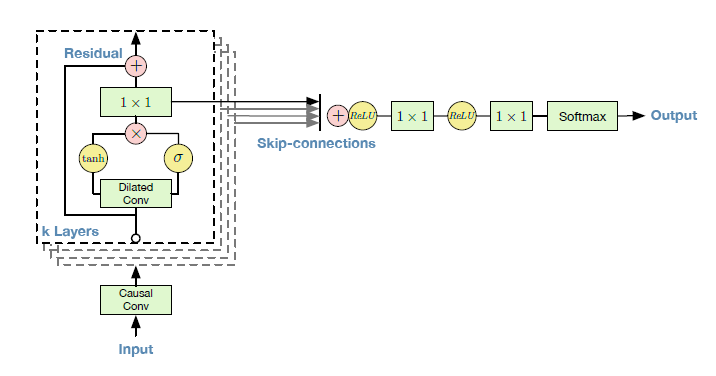

Fig.1 [1]

* ResidualBlockは、Fig.1の1つの四角のブロックに該当します。
    * r_channelsはResidualBlock内で各層が何チャネルを持つか定義しています
    * s_channelsは各スキップコネクションが何チャネルを持つか定義しています

In [13]:
# Model parameters for ResidualBlock
r_channels = 64  # Number of channels in residual layers and embedding
s_channels = 256  # Number of channels in the skip layers

In [14]:
class ResidualBlock(nn.Module):
    def __init__(
            self,
            filter_size,
            dilation,
            residual_channels,
            dilated_channels,
            skip_channels
    ):
        super().__init__()
        pad = dilation * (filter_size - 1)
        self.conv = nn.Conv2d(residual_channels, dilated_channels, (filter_size, 1), padding=(pad, 0), dilation=(dilation, 1))
        self.res = nn.Conv2d(dilated_channels // 2, residual_channels, 1)
        self.skip = nn.Conv2d(dilated_channels // 2, skip_channels, 1)

        self.filter_size = filter_size
        self.dilation = dilation
        self.residual_channels = residual_channels

    def forward(self, x, condition):
        length = x.shape[2]
        h = self.conv(x)
        h = h[:, :, :length]  # crop
        h += condition
        tanh_z, sig_z = h.split(h.shape[1] // 2, dim=1)
        z = torch.tanh(tanh_z) * torch.sigmoid(sig_z)
        if x.shape[2] == z.shape[2]:
            residual = self.res(z) + x
        else:
            residual = self.res(z) + x[:, :, -1:]  # crop
        skip_connection = self.skip(z)
        return residual, skip_connection

    def initialize(self, n, device):
        self.queue = torch.zeros(n, self.residual_channels, self.dilation * (self.filter_size - 1) + 1, 1).to(device)
        self.conv.padding = (0, 0)

    def pop(self, condition):
        return self(self.queue, condition)

    def push(self, x):
        self.queue = torch.cat((self.queue[:, :, 1:], x), dim=2)

ResidualBlockの中では、通常のConvolution層とは異なり、DilatedConvolutionが使用されています(Fig.2)。

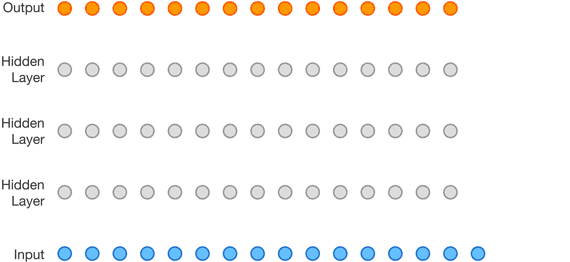

Fig.2 [3]

次に、ResidualBlockを重ねて、ResidualNetを作ります。

* ResidualNetは、Fig.1のすべての四角のブロックに該当します。
    * n_layerはResidualBlockで隠れ層をいくつ作るか定義しています。Fig.2で言うと、隠れ層の数に該当します。
    * n_loopはResidualBlock全体を何回ループさせるかを定義しています。Fig.2の部分を何ループさせるかに該当します。

In [15]:
# Model parameters for ResidualNet
n_layer = 10  # Number of layers in each residual block
n_loop = 2  # Number of residual blocks

In [16]:
class ResidualNet(nn.Module):
    def __init__(
            self,
            n_loop,
            n_layer,
            filter_size,
            residual_channels,
            dilated_channels,
            skip_channels
    ):
        super().__init__()
        dilations = [2 ** i for i in range(n_layer)] * n_loop
        self.layers = nn.ModuleList([
            ResidualBlock(filter_size, dilation, residual_channels, dilated_channels, skip_channels)
            for dilation in dilations
        ])

    def forward(self, x, conditions):
        for i, (func, cond) in enumerate(zip(self.layers, conditions)):
            x, skip = func(x, cond)
            if i == 0:
                skip_connections = skip
            else:
                skip_connections += skip
        return skip_connections

    def initialize(self, n, device):
        for block in self.layers:
            block.initialize(n, device)

    def generate(self, x, conditions):
        for i, (func, cond) in enumerate(zip(self.layers, conditions)):
            func.push(x)
            x, skip = func.pop(cond)
            if i == 0:
                skip_connections = skip
            else:
                skip_connections += skip
        return skip_connections

上記のモジュールを組み合わせてWaveNetのネットワークを定義します。

* WaveNetは、Fig.1の全体に該当します。ResidualNetとConvolution層を組み合わせて作られます。
    * a_channelsは出力チャネル数を定義しています。
    * use_embed_tanhは途中で活性化関数tanhを使用するか定義しています。

In [17]:
# Model parameters for WaveNet
a_channels = quantized_size  # Number of channels in the output layers
use_embed_tanh = True  # Use tanh after an initial 2x1 convolution

In [18]:
class WaveNet(nn.Module):
    def __init__(
            self,
            n_loop,
            n_layer,
            a_channels,
            r_channels,
            s_channels,
            use_embed_tanh
    ):
        super().__init__()
        self.embed = nn.Conv2d(a_channels, r_channels, (2, 1), padding=(1, 0), bias=False)
        self.resnet = ResidualNet(n_loop, n_layer, 2, r_channels, 2 * r_channels, s_channels)
        self.proj1 = nn.Conv2d(s_channels, s_channels, 1, bias=False)
        self.proj2 = nn.Conv2d(s_channels, a_channels, 1, bias=False)

        self.a_channels = a_channels
        self.s_channels = s_channels
        self.use_embed_tanh = use_embed_tanh

    def forward(self, x, condition, generating=False):
        length = x.shape[2]
        x = self.embed(x)
        x = x[:, :, :length, :]  # crop
        if self.use_embed_tanh:
            x = torch.tanh(x)
        z = F.relu(self.resnet(x, condition))
        z = F.relu(self.proj1(z))
        y = self.proj2(z)
        return y

    def initialize(self, n, device):
        self.resnet.initialize(n, device)

        self.embed.padding = (0, 0)
        self.embed_queue = torch.zeros(n, self.a_channels, 2, 1).to(device)
        self.proj1_queue = torch.zeros(n, self.s_channels, 1, 1).to(device)
        self.proj2_queue3 = torch.zeros(n, self.s_channels, 1, 1).to(device)

    def generate(self, x, condition):
        self.embed_queue = torch.cat((self.embed_queue[:, :, 1:], x), dim=2)
        x = self.embed(self.embed_queue)
        if self.use_embed_tanh:
            x = torch.tanh(x)
        x = F.relu(self.resnet.generate(x, condition))

        self.proj1_queue = torch.cat((self.proj1_queue[:, :, 1:], x), dim=2)
        x = F.relu(self.proj1(self.proj1_queue))

        self.proj2_queue3 = torch.cat((self.proj2_queue3[:, :, 1:], x), dim=2)
        x = self.proj2(self.proj2_queue3)
        return x

データセットを用意する部分で既に説明しましたが、今回spectrogramを条件づけとしてモデルを学習します。

spectrogramと他のデータではデータ長が異なるため、spectrogramをアップサンプリングする必要があります。UpsampleNetはそれを行うためのクラスです。

In [19]:
class UpsampleNet(nn.Module):
    def __init__(
            self,
            out_layers,
            r_channels,
            channels=[128, 128],
            upscale_factors=[16, 16]
    ):
        super().__init__()
        self.layers0 = nn.ModuleList([
            nn.ConvTranspose2d(channel, channel, (factor, 1), (factor, 1))
            for channel, factor in zip(channels, upscale_factors)
        ])
        self.layers1 = nn.ModuleList([
            nn.ConvTranspose2d(128, 2 * r_channels, 1)
            for _ in range(out_layers)
        ])

    def __call__(self, condition):
        conditions = []
        for func in self.layers0:
            condition = F.relu(func(condition))

        for func in self.layers1:
            conditions.append(func(condition))
        out = torch.stack(conditions)
        return out

WaveNetをdecoder、UpSampleNetをencoderとしてモデルを定義しましょう。

In [20]:
class EncoderDecoderModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def __call__(self, x, condition):
        encoded_condition = self.encoder(condition)
        y = self.decoder(x, encoded_condition)
        return y

定義したネットワークを使って、実際に学習を行うmodelを作成しましょう。

In [21]:
# Networks
encoder = UpsampleNet(n_loop * n_layer, r_channels)
decoder = WaveNet(n_loop, n_layer, a_channels, r_channels, s_channels, use_embed_tanh)
model = EncoderDecoderModel(encoder, decoder).to(device)

#5. 学習の準備と実行

Trainerを定義してmodelを学習させます。

In [22]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [23]:
class Trainer:
    def __init__(self, model, optim, divisor, out_dir):
        self.model = model
        self.optim = optim
        self.divisor = divisor
        self.out_dir = out_dir

        self.loss = 0
    
    def fit(self, one_hot, spectrogram, quantized):
        self.optim.zero_grad()

        pred = self.model(one_hot, spectrogram)
        pred = pred.squeeze(-1)
        quantized = quantized.squeeze(-1)

        loss = F.cross_entropy(pred, quantized)
        loss.backward()

        self.optim.step()

        self.loss += loss.item() / self.divisor
    
    def set_loss(self):
        self.loss = 0

    def save_model(self, global_steps):
        torch.save(self.model.state_dict(), '{}/snapshot_iter_{}.pth'.format(self.out_dir, global_steps))

In [24]:
trainer = Trainer(
    model=model,
    optim=optimizer,
    divisor=display_interval,
    out_dir=out_dir
)

(以前に学習させてその途中結果がsnapshotとして、./drive/wavenet/result/以下に保存されています。そこから再開させるためのコードです。はじめての場合に実行しても、特に何も起きません。)

In [25]:
import glob


# Resume latest snapshot if exists
model_files = glob.glob(out_dir + '/snapshot_iter_*')
if len(model_files) > 0:
    model_files = sorted(map(lambda x: int(x.split('/snapshot_iter_')[-1].replace('.pth', '')), model_files))
    resume = glob.glob(out_dir + '/snapshot_iter_' + str(model_files[-1]) + '.pth')[0]
    print('model: {}'.format(resume))
    param = torch.load(resume)
    model.load_state_dict(param)

model: ./drive/wavenet/result/snapshot_iter_10000.pth


In [26]:
import time


global_steps = 0
start_time = time.time()

# Run
print('start train')
for e in range(epoch):
    for i, data in enumerate(train_iter):
        global_steps += 1

        one_hot, spectrogram, quantized = data

        one_hot = one_hot.to(device, non_blocking=True)
        spectrogram = spectrogram.to(device, non_blocking=True)
        quantized = quantized.to(device, non_blocking=True)

        trainer.fit(one_hot, spectrogram, quantized)

        if global_steps % display_interval == 0:
            print('-' * 50)
            print('epoch: {}  g_steps: {}  time: {:.1f}'.format(e + 1, global_steps, time.time() - start_time))
            print('    loss: {:.5f}'.format(trainer.loss))

            trainer.set_loss()
        
        if global_steps % snapshot_interval == 0:
            trainer.save_model(global_steps)

start train
--------------------------------------------------
epoch: 1  g_steps: 100  time: 42.2
    loss: 2.40424
--------------------------------------------------
epoch: 1  g_steps: 200  time: 82.5
    loss: 2.41330
--------------------------------------------------
epoch: 1  g_steps: 300  time: 123.2
    loss: 2.36217
--------------------------------------------------
epoch: 1  g_steps: 400  time: 164.2
    loss: 2.39492
--------------------------------------------------
epoch: 1  g_steps: 500  time: 205.0
    loss: 2.39174
--------------------------------------------------
epoch: 1  g_steps: 600  time: 245.8
    loss: 2.39095
--------------------------------------------------
epoch: 1  g_steps: 700  time: 286.3
    loss: 2.43663
--------------------------------------------------
epoch: 1  g_steps: 800  time: 326.6
    loss: 2.43602
--------------------------------------------------
epoch: 1  g_steps: 900  time: 366.3
    loss: 2.38193
---------------------------------------------

KeyboardInterrupt: ignored

#6. テストデータでの性能の確認

最新の学習結果を使って、実際に音声を合成してみましょう。(最低でも5epochくらいは学習させないと、似た音が出ているか判別できないです。)

In [27]:
pip install soundfile

In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [29]:
import glob
model_files = glob.glob(out_dir + '/snapshot_iter_*')
model_files = sorted(map(lambda x: int(x.split('/snapshot_iter_')[-1].replace('.pth', '')), model_files))
model_files

[1000,
 2000,
 3000,
 4000,
 5000,
 6000,
 7000,
 8000,
 9000,
 10000,
 11000,
 12000,
 13000,
 14000,
 15000,
 16000,
 17000,
 18000,
 19000,
 20000,
 21000,
 22000,
 23000,
 24000,
 25000,
 26000,
 27000,
 28000,
 29000,
 30000,
 31000]

In [30]:
model_file = glob.glob(out_dir + '/snapshot_iter_' + str(model_files[-1]) + '.pth')[0]
print(model_file)
input_file = './VCTK-Corpus/wav48/p225/p225_001.wav'
output_file = './drive/wavenet/result.wav'

./drive/wavenet/result/snapshot_iter_31000.pth


In [44]:
# Define networks
encoder = UpsampleNet(n_loop * n_layer, r_channels)
decoder = WaveNet(n_loop, n_layer,a_channels, r_channels, s_channels, use_embed_tanh)
model = EncoderDecoderModel(encoder, decoder).to(device)

In [45]:
# Load trained parameters
param = torch.load(model_file)
model.load_state_dict(param)

<All keys matched successfully>

In [81]:
# Preprocess
_, condition, _ = Preprocess(
    sr=16000, n_fft=1024, hop_length=256, n_mels=128, top_db=20,
    length=None, quantize=a_channels)(input_file)

In [82]:
import tqdm
import soundfile as sf


model.eval()

with torch.no_grad():

    # Non-autoregressive generate
    x = torch.zeros(1, a_channels, 1, 1).to(device)
    condition = torch.Tensor(condition).unsqueeze(0).to(device)
    conditions = model.encoder(condition)
    model.decoder.initialize(1, device=device)
    output = torch.zeros(conditions.shape[3]).to(device)

    sound_prob = torch.zeros(len(output), quantized_size)

    # Autoregressive generate
    for i in tqdm.tqdm(range(len(output))):
        out = model.decoder.generate(x, conditions[:, :, :, i:i + 1])
        
        sound_prob[i] = F.softmax(out, dim=1).reshape(1, quantized_size)
        
        value = np.random.choice(
            a_channels,
            size=1,
            p=F.softmax(out, dim=1).cpu().numpy().reshape(-1)
        )[0]
        # print(value)

        x = torch.zeros_like(x).to(device)
        x[:, value, :, :] = 1
        
        output[i] = value

# Save
output = output.cpu().numpy()
wave = MuLaw(a_channels).itransform(output)
sf.write(output_file, wave, 16000, subtype="PCM_16")

100%|██████████| 21248/21248 [02:46<00:00, 127.51it/s]


In [83]:
import IPython.display
IPython.display.Audio(output_file)

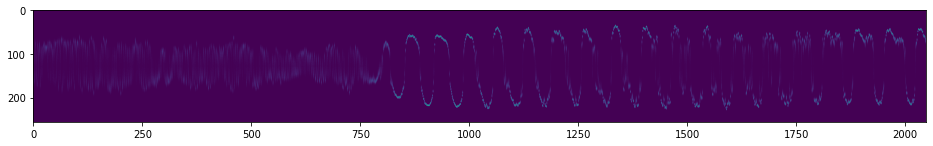

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 9))
plt.imshow(sound_prob.t().cpu().numpy()[:, :2048])

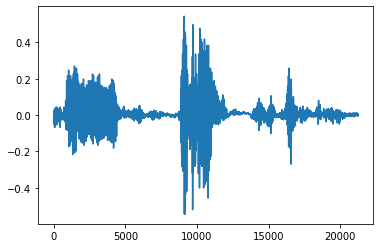

In [85]:
plt.plot(wave)